In [231]:
import import_ipynb
from generate_false_SOC_VNIR_spectra import *

import torch
import torch .nn as nn
import torch .optim as optim

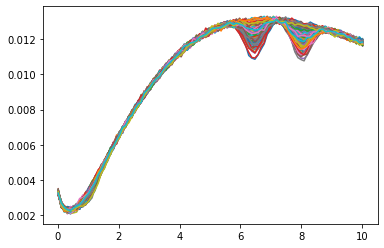

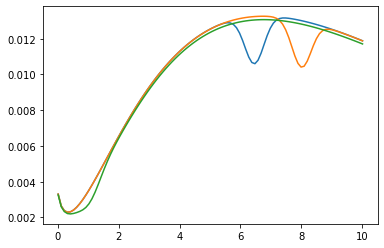

In [773]:
import matplotlib.pyplot as plt

XF, A, F, I, cents = generateFalseData(300,100,3,0.02,0)
plt.plot(XF, I.T)
plt.show()

plt.plot(XF, F.T)
plt.show()

In [790]:
def get_quantile_diff_dist(tI, q) :
    NN = tI.shape[0]
    diffs = np.zeros([int(NN*(NN-1)/2),tI.shape[1]])
    
    ind=0
    for i in range(NN) :
        for j in range(i) :
            diffs[ind,:] = (tI[i,:] - tI[j,:])**2
            ind+=1
    
    return np.quantile(diffs, q, axis=0)

In [791]:
vlamb95 = get_quantile_diff_dist(I,0.68)

In [792]:
def compute_loss(fi,fj,si,sj) :
    tc = (fi-fj)**2
    th = (tc < vlamb95).astype('float')
    tc = np.sum(tc*th)/np.sum(th)
    ts = (si-sj)**2
    
    return tc-ts
    

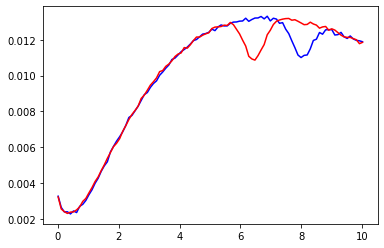

In [793]:
lowest_loss = float('inf')
lowest_loss_i = 0
lowest_loss_j = 1

for i in range(I.shape[0]) :
    for j in range(i) :
        tfi = I[i,:]
        tfj = I[j,:]
        tsi = A[0,i]
        tsj = A[0,j]
        
        tloss = compute_loss(tfi,tfj,tsi,tsj)
        if tloss < lowest_loss :
            lowest_loss = tloss
            lowest_loss_i = i
            lowest_loss_j = j
            
plt.plot(XF, I[lowest_loss_i,:],color='b')
plt.plot(XF, I[lowest_loss_j,:],color='red')
plt.show()

In [794]:
print(cents)

[6.45507177 8.00635973 1.06993127]


In [795]:
print(A[:,lowest_loss_i])
print(A[:,lowest_loss_j])
print(lowest_loss)

[0.00499717 0.73186952 0.26313331]
[0.91059542 0.01374479 0.07565979]
-0.820108175911685


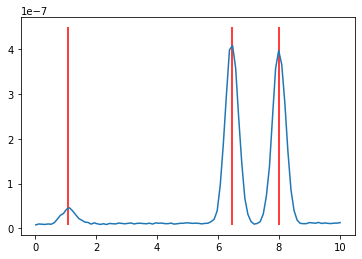

In [796]:
plt.plot(XF, vlamb95)
plt.vlines(x=cents,ymin=min(vlamb95),ymax=max(vlamb95)*1.1, color='r')
plt.show()

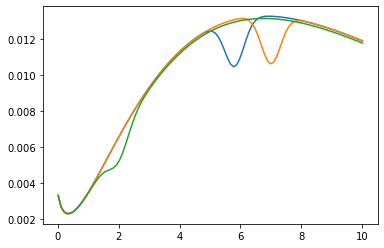

In [797]:
seedAs = torch.tensor((np.ones(A.shape)[1:,:]*(1.0-A[0,:])/(A.shape[0]-1)).tolist())
seedFs = torch.tensor(generatePureFs(100, [5.8,7.0,2.0], noiseV=0, noiseB=0).tolist())
ys = (torch.tensor(A[0,:].tolist()),torch.tensor(I.tolist()),torch.tensor(np.max(I,axis=0).tolist()))

plt.plot(XF, (seedFs.T/torch.sum(seedFs,1)).detach().numpy());


In [782]:
seedAs = torch.tensor((np.ones(A.shape)[1:,:]*(1.0-A[0,:])/(A.shape[0]-1)).tolist())
seedFs = torch.tensor(generatePureFs(100, [6.5,4.5,0.5], noiseV=0, noiseB=0).tolist())
ys = (torch.tensor(A[0,:].tolist()),torch.tensor(I.tolist()),torch.tensor(np.max(I,axis=0).tolist()))

class LinearMixingModel(nn.Module):
    def __init__(self, seedF, seedA):
        super().__init__()
        self.fs     = nn.Parameter(seedF)
        self.alphas = nn.Parameter(seedA)
        self.Ihat = 0;
        
    def forward(self, y):
        As,Is,Imax = y
        alphFull = torch.transpose(torch.cat((As.unsqueeze(1),torch.transpose(self.alphas,0,1)),dim=1),0,1)
        self.Ihat = torch.matmul(self.fs.T/torch.sum(self.fs,1),alphFull)
                
        # Add in a fake Lagrange multiplier to discourage abundances < 0.01 or > 0.99
        oobsA = torch.sum((-1.0 * (alphFull < 0.01).float() + (alphFull > 0.99).float()) * alphFull)

        # Add in a fake Lagrange multiplier to discourage Fs < 0
        oobsF = -1.0 * torch.sum((self.fs < 0.0).float() * self.fs)

        # Add in a fake Lagrange multiplier to discourage reflectances in F's that are above empirical max
        omrs = torch.sum(((self.fs.T/torch.sum(self.fs,1)).T > Imax.T.repeat(3,1)).float() * ((self.fs.T/torch.sum(self.fs,1)).T - Imax.T.repeat(3,1)))
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.fs) ** 2)
        diffloss += torch.sum(torch.diff(torch.diff(self.fs)) ** 2)
        
        # Compute the loss function, which is the mean-squared error between data and prediction,
        # with a multiplicative factor for our fake Lagrange multipliers
        return torch.sum((Is.T - self.Ihat) ** 2) * (1 + 10000.0*omrs + 100.0* diffloss + 100.0*oobsA + 1000.0*oobsF)


model = LinearMixingModel(seedFs,seedAs)
optimizer = optim.Adam(model.parameters(), lr = 0.1)

for epoch in range(200000) :
    loss = model(ys)
    e = torch.mean(loss)
    e.backward()
    optimizer.step()
    optimizer.zero_grad()

    #print("Epoch ",epoch,": ", loss.detach().item())

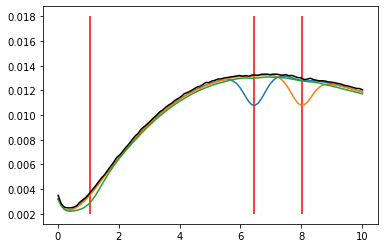

In [783]:
plt.plot(XF, (model.fs.T/torch.sum(model.fs,1)).detach().numpy());
plt.plot(XF, (np.max(I,axis=0)).T,'black');
plt.vlines(cents,0.002,0.018,'r');


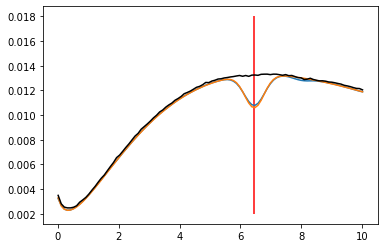

In [784]:
plt.plot(XF, (model.fs.T/torch.sum(model.fs,1)).detach().numpy()[:,0]);
plt.plot(XF, F.T[:,0]);
plt.plot(XF, (np.max(I,axis=0)).T,'black');
plt.vlines(cents[0],0.002,0.018,'r')

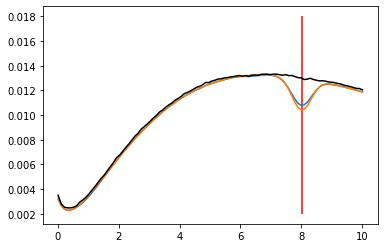

In [785]:
plt.plot(XF, (model.fs.T/torch.sum(model.fs,1)).detach().numpy()[:,1]);
plt.plot(XF, F.T[:,1]);
plt.plot(XF, (np.max(I,axis=0)).T,'black');
plt.vlines(cents[1],0.002,0.018,'r')

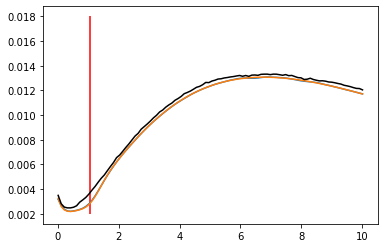

In [786]:
plt.plot(XF, (model.fs.T/torch.sum(model.fs,1)).detach().numpy()[:,2]);
plt.plot(XF, F.T[:,2]);
plt.plot(XF, (np.max(I,axis=0)).T,'black');
plt.vlines(cents[2],0.002,0.018,'r')

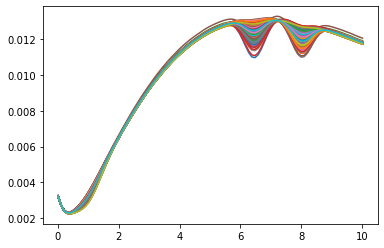

In [787]:
plt.plot(XF, model.Ihat.detach().numpy());

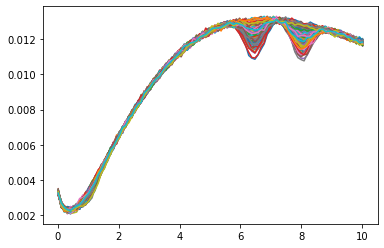

In [788]:
plt.plot(XF, I.T);

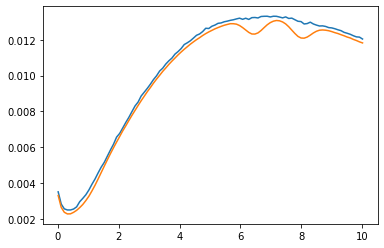

In [789]:
plt.plot(XF, np.max(I,axis=0).T);
plt.plot(XF, np.mean(I,axis=0).T);